Abbruch in Abschnitt 87:
cum_length = 1.918 m
T_fl_neu = 293.67 K, theta_m = 0.9909
T_amb = 293.15 K
T_fl_neu = 293.67 K
T_fl - T_amb = 1.693102 K
Kondensatmenge = 83.11466832152934 ml
alpha = 12.618913757985565 W/m^2*K
R_w = 0.0005011299347178104 K/W
Q_Kd,ges = 12.91006315579922
A_M_Kd =  0.26966087190786286


/var/folders/kj/m9c2r7t13jd_mxv4qfg47ndr0000gn/T/ipykernel_4330/912291051.py:498: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([pd.DataFrame([erste_zeile]), df], ignore_index=True)


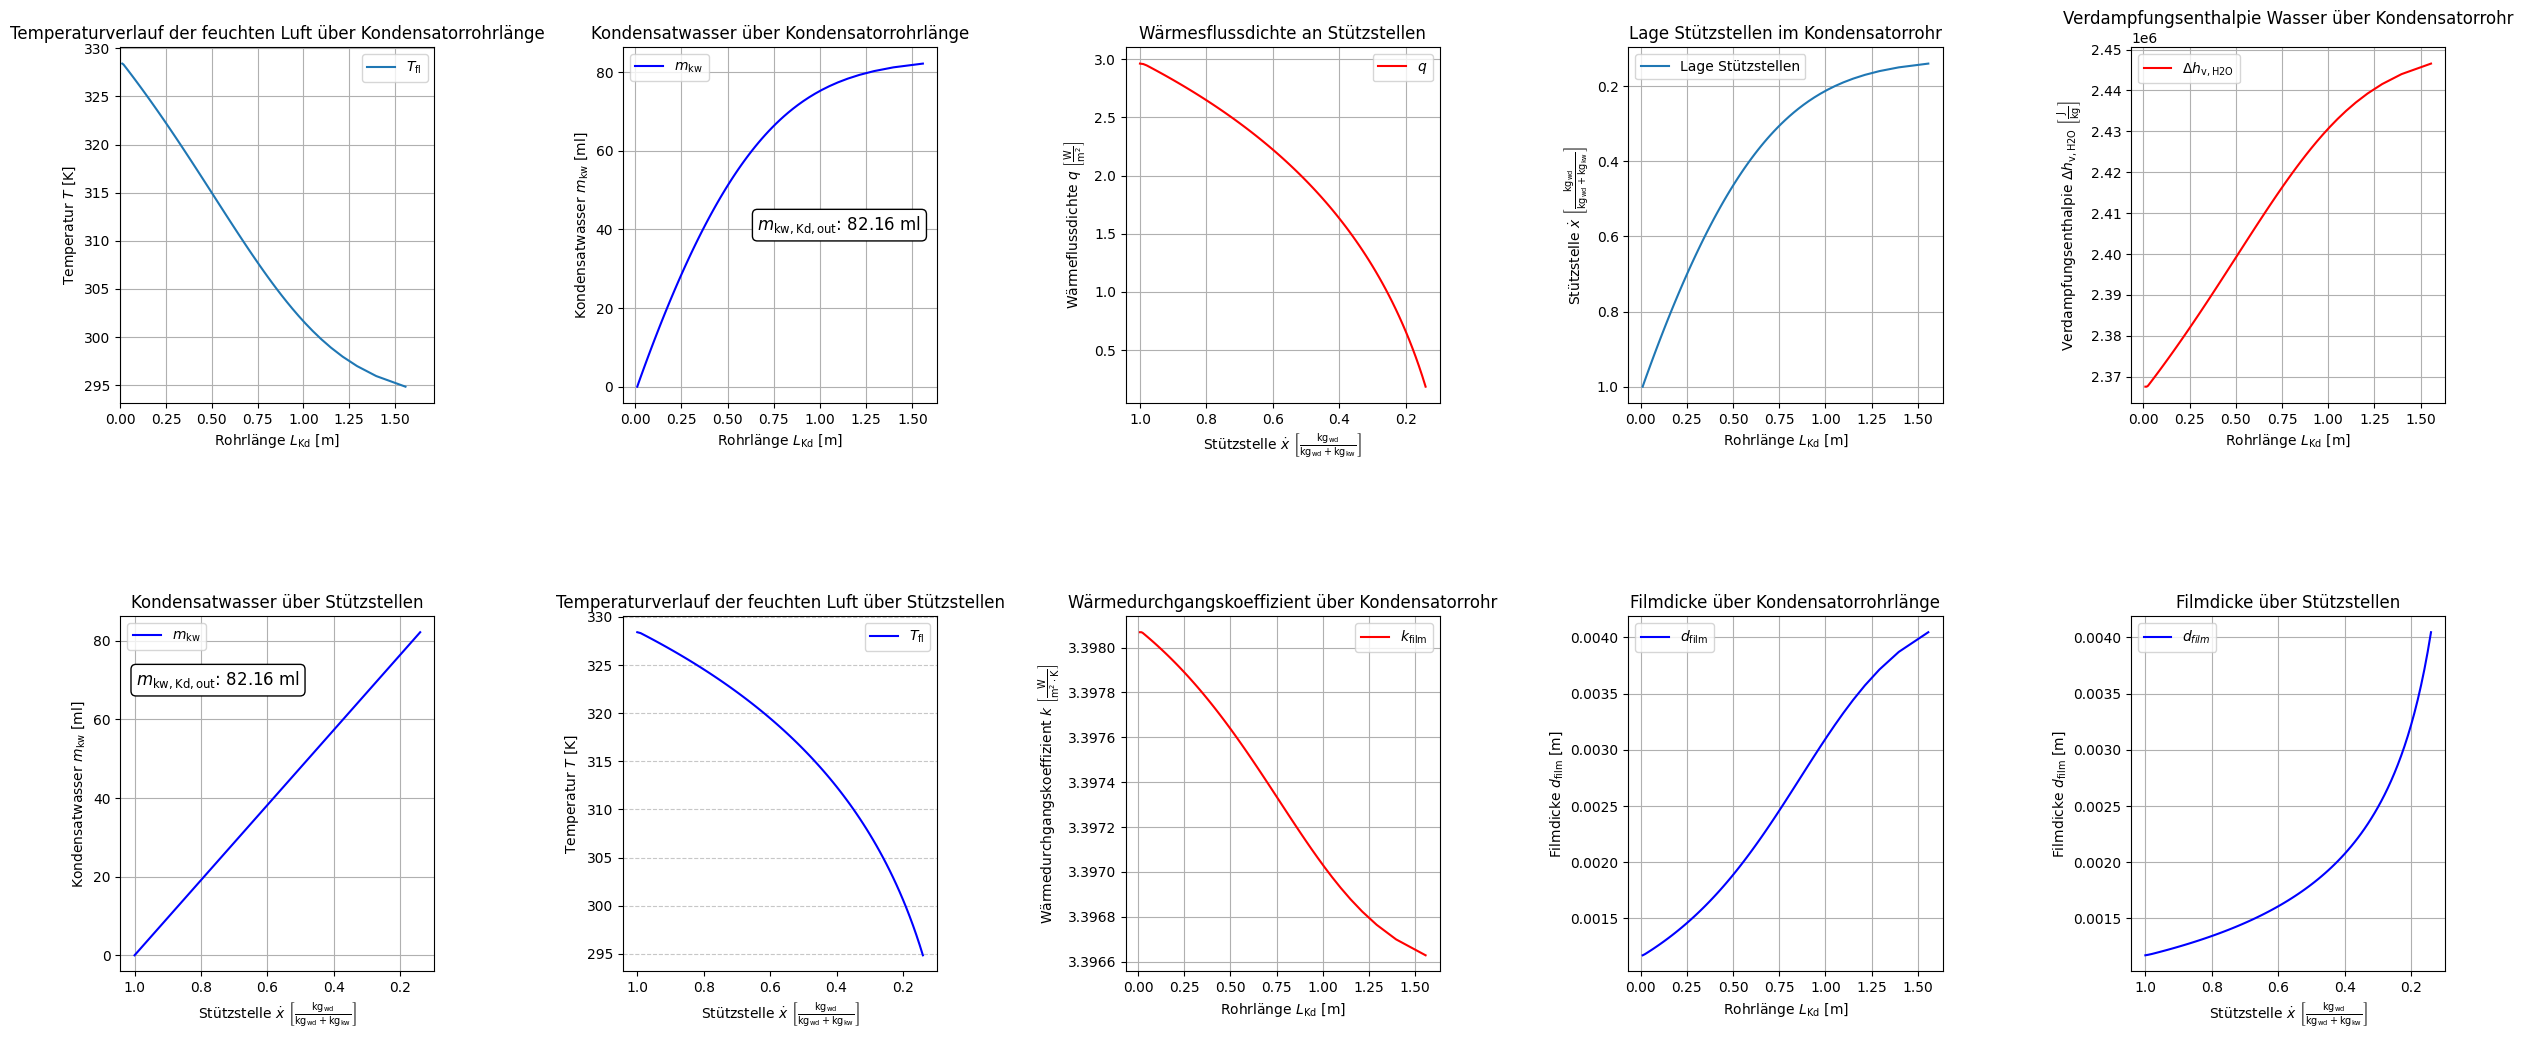

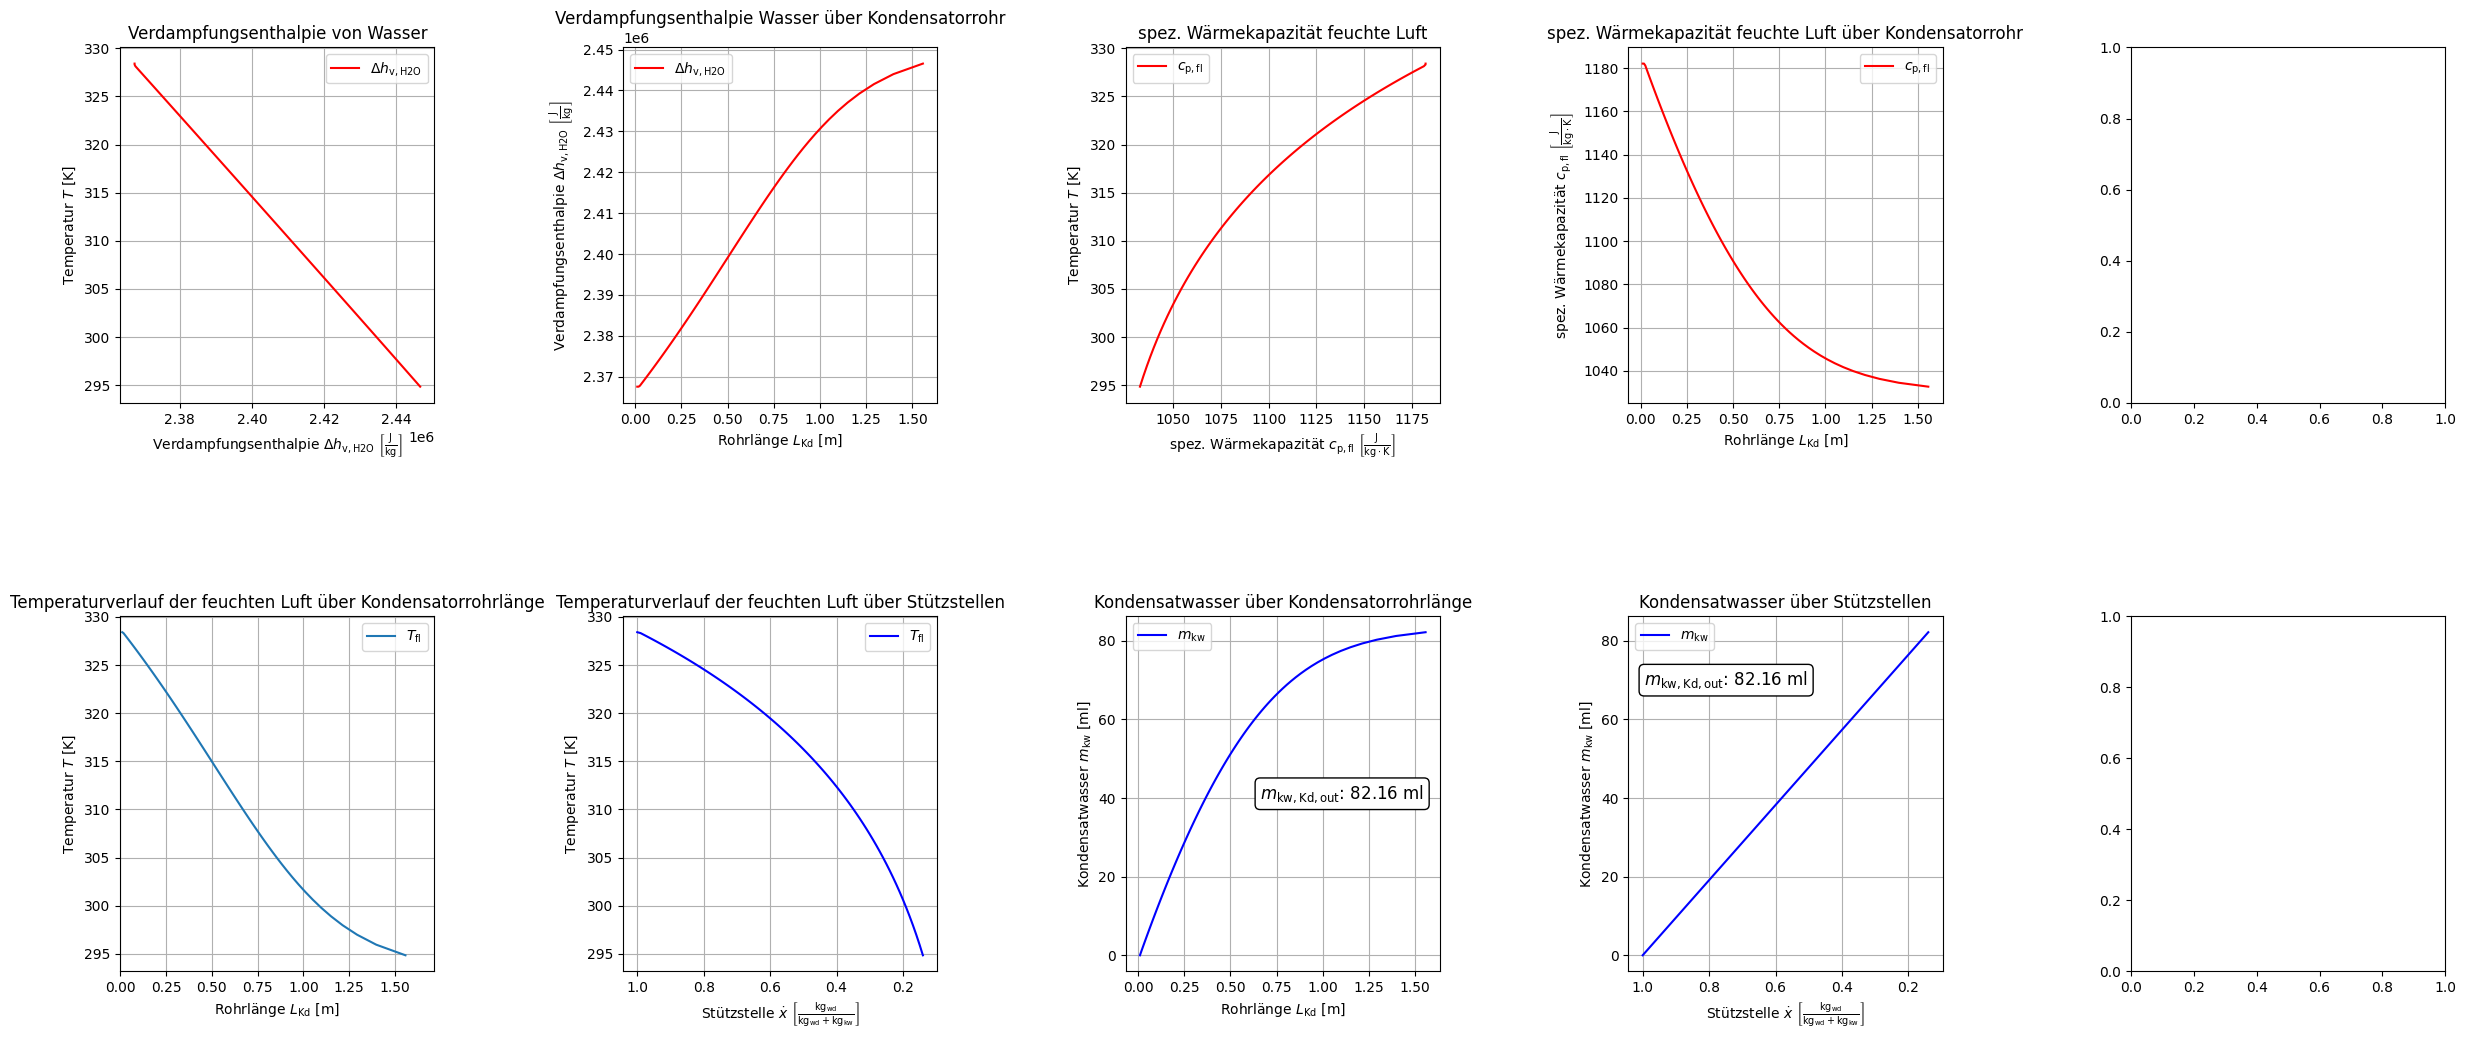

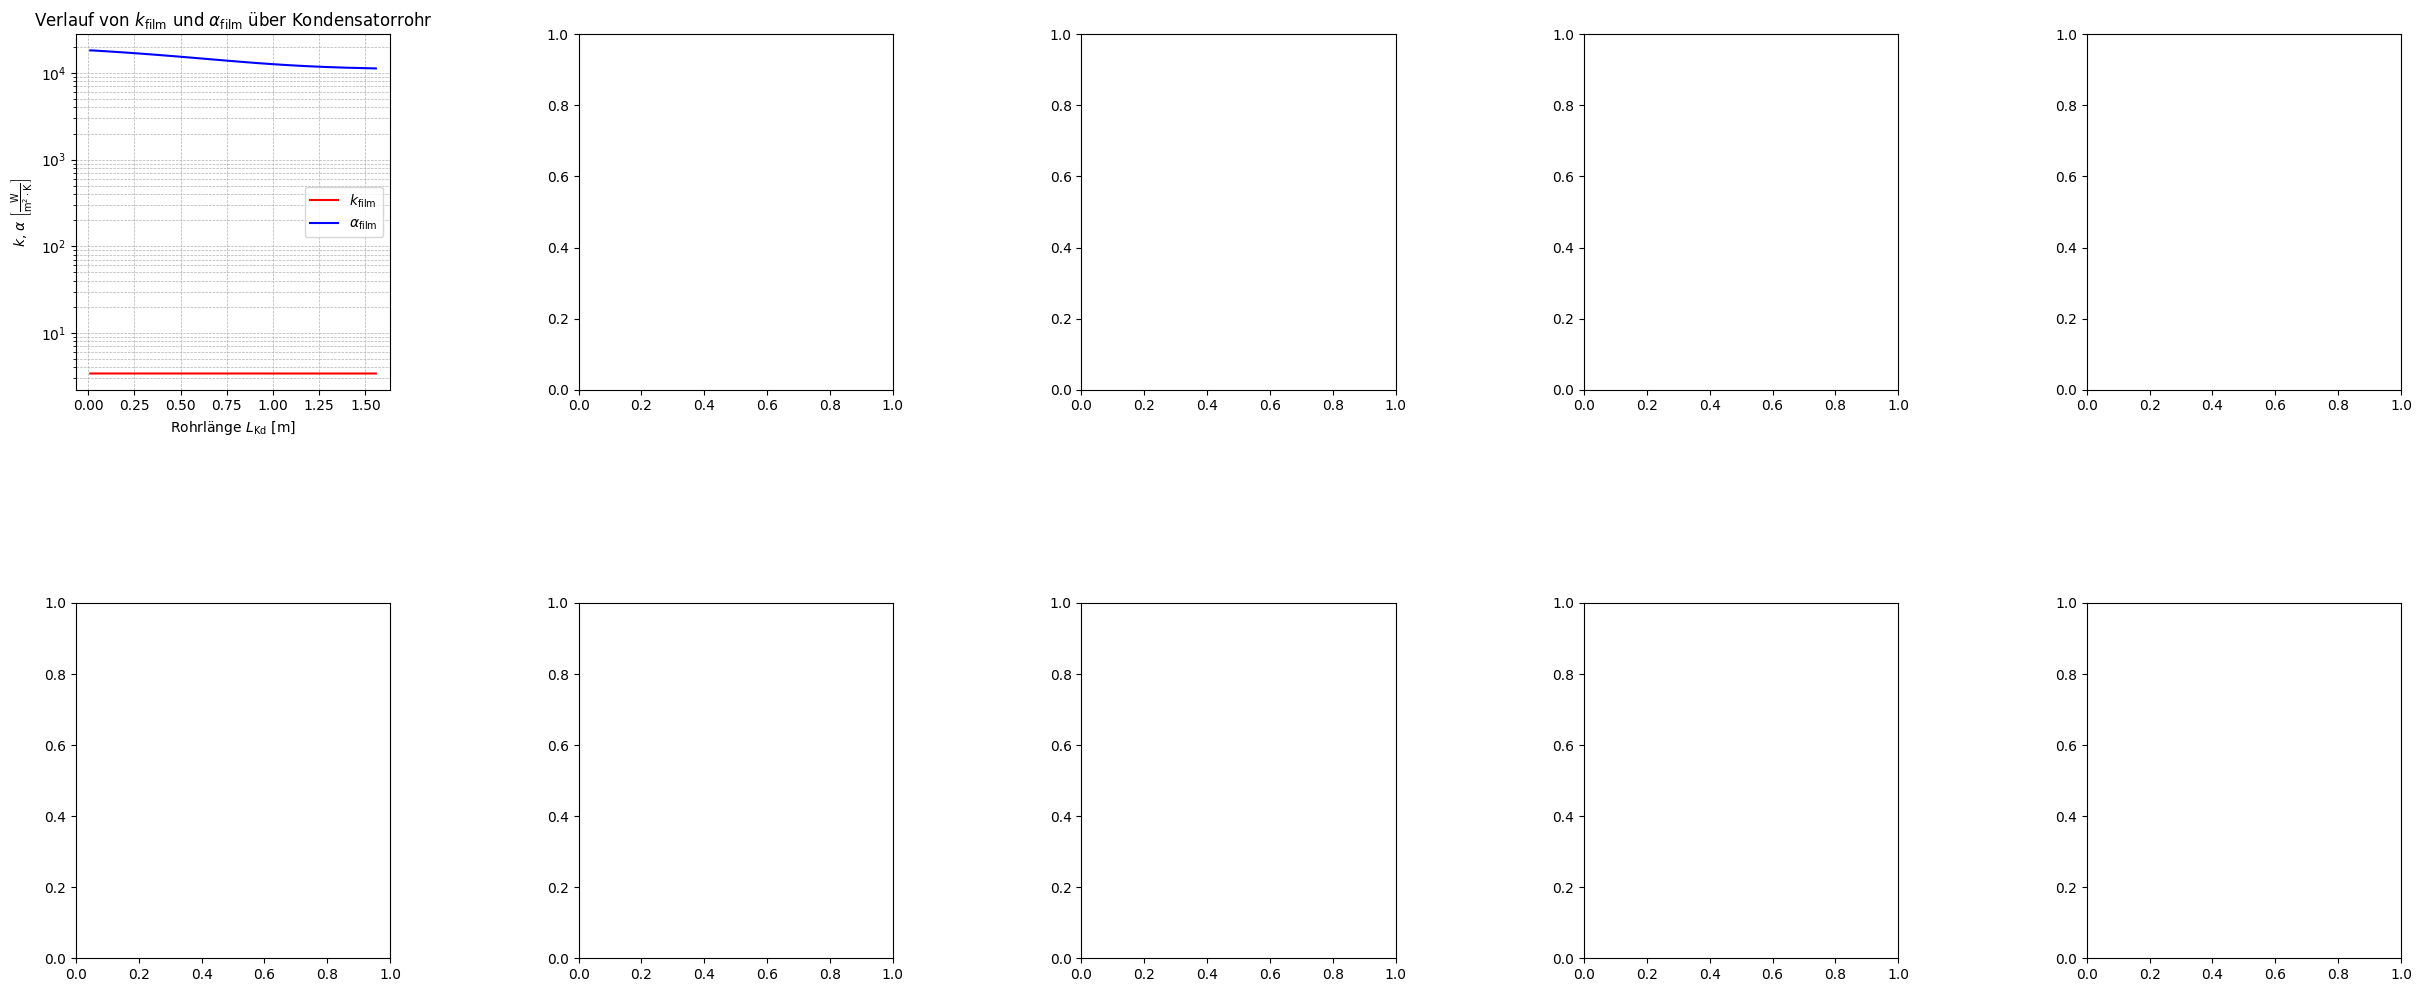

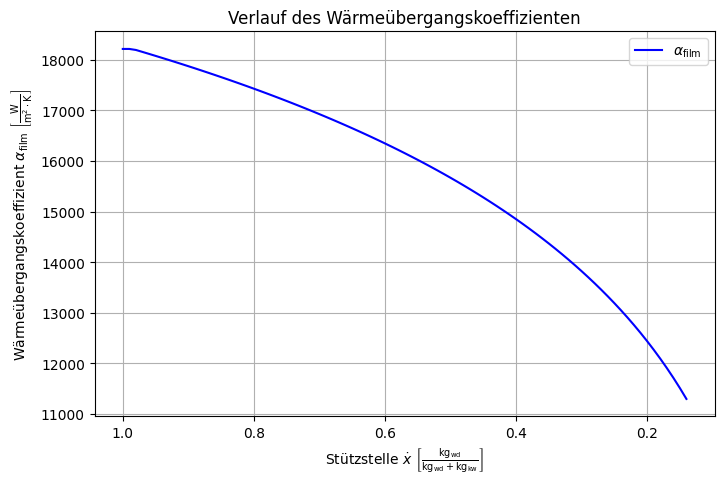

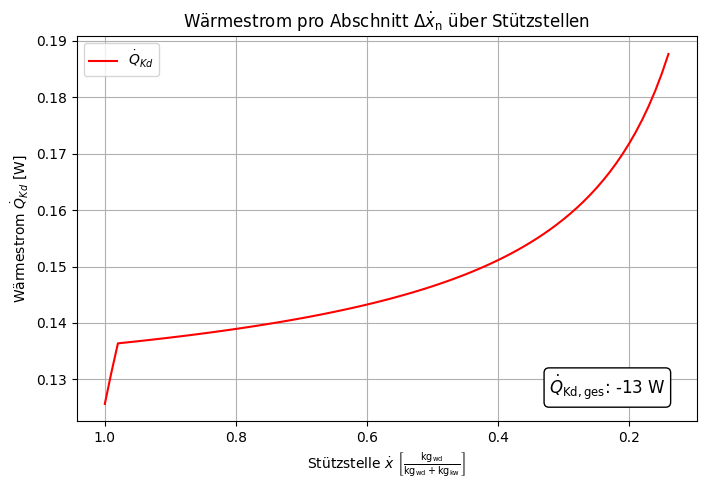

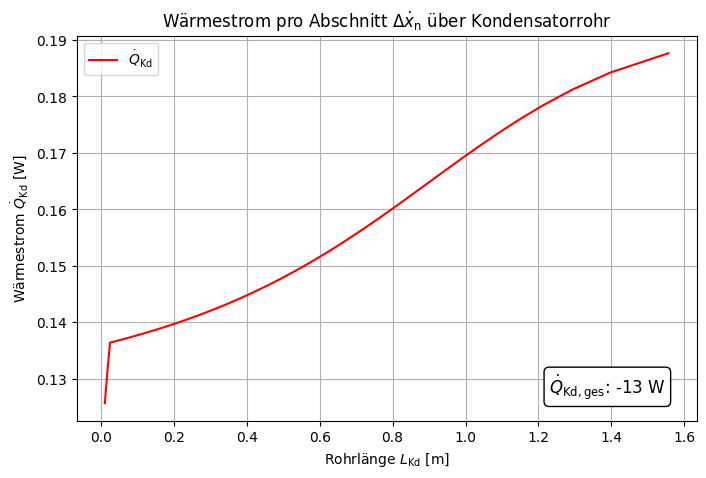

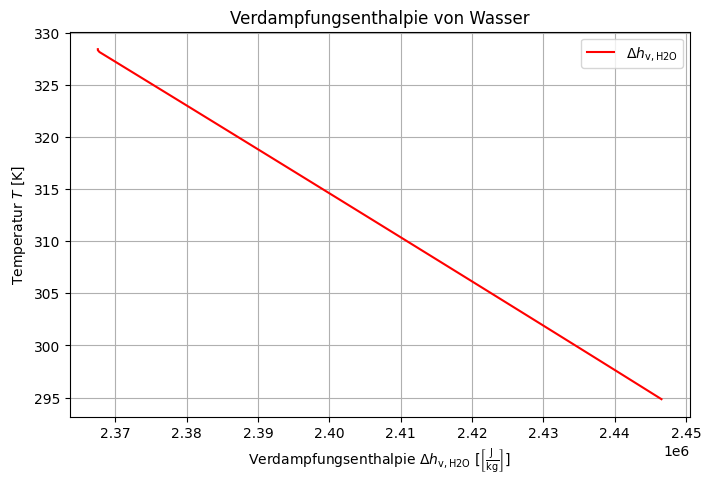

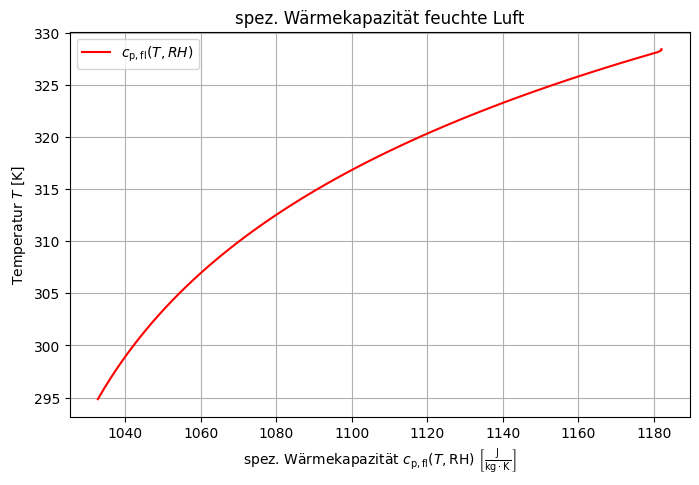

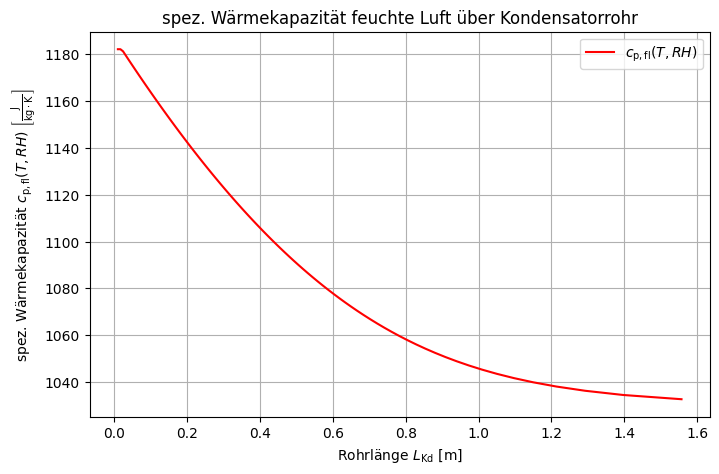

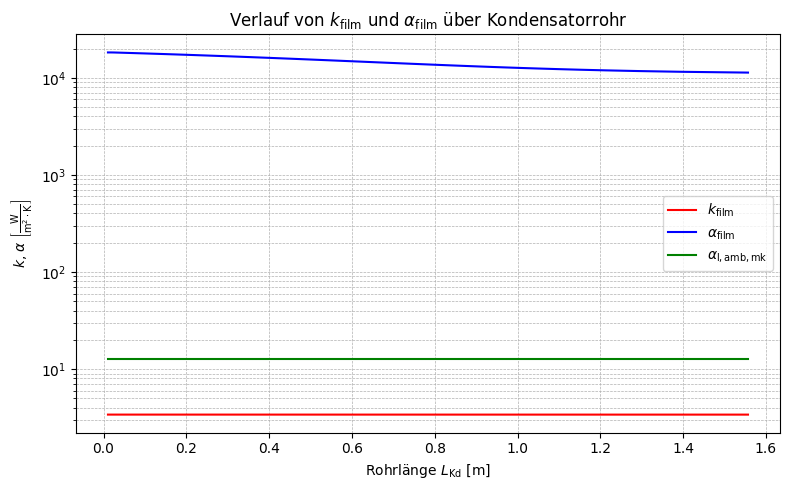

In [ ]:
# Pakete
import math 
from math import pi
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import psychrolib
from psychrolib import (
    SI, GetHumRatioFromRelHum, GetMoistAirEnthalpy,
    GetMoistAirDensity, GetStandardAtmPressure, GetTDewPointFromRelHum, GetDryAirDensity,
    GetRelHumFromHumRatio,GetTWetBulbFromHumRatio, GetTDewPointFromHumRatio, GetSatVapPres,
    GetVapPresFromRelHum, GetHumRatioFromVapPres
)
psychrolib.SetUnitSystem(SI)    # Einheitensystem auf SI (°C, kg/kg, Pa, etc.)

from CoolProp.CoolProp import PropsSI
# 'T'	        Temperatur	                K
# 'P'	        Druck	                    Pa
# 'H'	        Enthalpie   	            J/kg
# 'S'	        Entropie	                J/kg·K
# 'L'           Wärmeleitfähigkeit          W/m*K
# 'D'	        Dichte	                    kg/m³
# 'C'	        spezifische Wärmekapazität  J/kg*K
# 'V'           dyn. Viskosität             Pa/s

from CoolProp.HumidAirProp import HAPropsSI
# 'Visc', 'M', 'mu'     dyn. Viskosität         Pa/s
# 'K', 'Conductivity'   Wärmeleitfähigkeit      W/m*K
# 'C'                   spez. Wärmekapazität    J/kg*K

import matplotlib.pyplot as plt


#============================================================================================================================================================================
# Variable Parameter, messbar
p_amb = 1.01325                 # bar
RH_amb = 0.3                   # *100 % (rel. Luftfeuchte Umgebung)
RH_in = 0.8                    # *100 % (rel. Luftfeuchte feuchte Luft Eintritt Kondensator)
T_amb = 20 + 273.15             # K (Temperatur Umgebungsluft)
T_in = 60 + 273.15              # K (Temperatur Feuchte Luft Eintritt Kondensator)
T_out = 30 + 273.15             # K (Temperatur Feuchute Luft Austritt Kondensator) !!!Annahme, dass feuchte Luft am Austritt des Kondensators die selbe Temperatur hat.!!!
m_punkt_fl_in = 5.075*10**-5   # kg_fl/s (Massenstrom feuchte Luft Eintritt Kondensator 5.075*10**-5) oder 4.5675*10**-5
u_l_amb = 0.1                   # m/s (Geschwindigkeit Luftstrom um Kondensator)
t_des = 5 * 3600                # s (Desorptionsdauer)         
T_kond = T_amb + 5   # K (gemittelte Kondesatortemperatur bei Desorption, ANNAHME: Kondensatortemp = Umgebungstemperatur + 5 K)

#============================================================================================================================================================================
# 50 um Plastikschlauch
# Geometrie 
L_kond = 1.715                     # m (Länge Rohr)
d_i_kond = 0.050                   # m (Innendurchmesser)
d_a_kond = 0.0501                 # m (Außendurchmesser)
s_kond = 0.00005                   # m (Wandstärke)
A_i_kond = pi*d_i_kond*L_kond      # m^2 (Mantelfläche Innen)
A_a_kond = pi*d_a_kond*L_kond      # m^2 (Mantelfläche Außen)
A_m_kond = (A_a_kond-A_i_kond)/math.log(A_a_kond/A_i_kond)   # m^2 (Mantelfläche gemittelt innen und außen), VDI S.24

# Stoffwerte https://de.wikipedia.org/wiki/Polyethylen
lambda_kond = 0.37   # W/m*K (Wärmeleitfähigkeit bei <23°C, Wärmeleitung von 1 K auf 1 m^2)


#============================================================================================================================================================================
# Konstanten
Pr_l = 0.7          # / (Prandtl-Zahl, Stoffwert-Verhältnis Pr=(eta*c_p)/Lambda), Verhältnis von Impuls- und Wäremediffusion -> als konst. im temperaturbereich 0-100 °C angenommen)
R = 8.314462618     # J/mol*K (Allgemeine Gaskonstante)
g = 9.80665         # m/s²  (Standard-Erdbeschleunigung nach ISO)
R_tl = 287.058      # J/kg*K (spez. Gaskonstante trockene Luft) R_s = R/M_s
R_d = 461.523       # J/kg*K  (spez. Gaskonstante Wasserdampf)
p_in = p_amb        # bar (Druck feuchte Luft Eintritt Kondensator)
p_out = p_amb       # bar (Druck feuchte Luft Austritt Kondensator)
T_k_H2O = 647.096     # K (kritische Temperatur Wasser)
M_H2O = 0.01801528  # kg/mol (Molare Masse von Wasser)


#============================================================================================================================================================================
# Variable Parameter, nicht messbar
    

def get_verdampfungsenthalpie(T_C):        # temperaturabhängige Berechnung von Verdampfungsenthalpie von Wasser
 # Parameter A-E aus VDI-Wärmeatlas S. 381
    A = 6.85307
    B = 7.43804
    C = -2.937595
    D = -3.282093
    E = 8.397378
    # Temperaturbereich in Kelvin (0 °C bis 100 °C)
    T = np.linspace(273.15, 373.15, 100)
    T_K = T_C + 273.15  # Temperatur in °C für Plot
    Tr = T_K / T_k_H2O
    one_minus_Tr = 1 - Tr
    
    # Formel (9) komplett
    hv_H2O_mol = (
        R * T_k_H2O * (
        A * one_minus_Tr**(1/3)
        + B * one_minus_Tr**(2/3)
        + C * one_minus_Tr
        + D * one_minus_Tr**2
        + E * one_minus_Tr**6
        )
    )
    hv_H2O = hv_H2O_mol / M_H2O
    return hv_H2O # J/kg


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Trockene Luft
def get_dichte_tl(T_K):
    rho_tl = PropsSI('D', 'T', T_K, 'P', 101325, 'Air')   # kg/m^3 (Dichte trockene Luft)
    return rho_tl

def get_waermekapazitaet_tl(T_K):
    c_p_tl = PropsSI('C', 'T', T_K, 'P', 101325, 'Air')   # J/kg*K (Wärmekapazität trockene Luft)
    return c_p_tl

def get_dyn_viskositaet_tl(T_K):
    eta_tl = PropsSI('VISCOSITY', 'T', T_K, 'P', 101325, 'Air') # Pa*s (dyn. Viskosität trockene Luft)
    return eta_tl
# eta_tl = 18.21e-6 # Pa*s (kin. Viskosität trockene Luft, 20°C)

def get_kin_viskositaet_tl(T_K):
    kin_viscosity_tl = get_dyn_viskositaet_tl(T_K)/get_dichte_tl(T_K)    # m^2/s (kin. Viskosität trockene Luft)
    return kin_viscosity_tl
# ny_tl = 153e-7 # m^2/s (dyn. Viskosität trockene Luft, 20°C)

def get_waermeleitfaehigkeit_tl(T_K):
    lambda_tl = PropsSI('L', 'T', T_K, 'P', 101325, 'Air')    # W/(m*K) (Wärmeleitfähigkeit trockene Luft)
    return lambda_tl
#lambda_tl = 25.87 / 1000 # W/(m*K) (Wärmeleitfähigkeit trockene Luft, 20°C)

def get_Prandtl_tl(T_K):
    Pr_tl = PropsSI('PRANDTL', 'T', T_K, 'P', 101325, 'Air')
    return Pr_tl

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Wasser
def get_dichte_H2O(T_K):
    rho_H2O = PropsSI('D', 'T', T_K, 'P', 101325, 'Water')   # kg/m^3 (Dichte Wasser, rho_w = 998.21 # kg/m^3 (Normbedingungen))
    return rho_H2O

def get_waermekapazitaet_H2O(T_K):
    c_p_H2O = PropsSI('C', 'T', T_K, 'P', 101325, 'Water')   # J/kg*K (Wärmekapazität Wasser)
    return c_p_H2O

def get_dyn_viskositaet_H2O(T_K):
    dyn_viskositaet_H2O = PropsSI('VISCOSITY', 'T', T_K, 'P', 101325, 'Water') # Pa*s (dyn. Viskosität Wasser)
    return dyn_viskositaet_H2O
# eta_w = 1001.6e-6 # Pa*s (dyn. Viskosität flüssiges Wasser, 20°C)

def get_kin_viskositaet_H2O(T_K):
   kin_viskositaet_H2O = get_dyn_viskositaet_H2O(T_K)/get_dichte_H2O(T_K)    # m^2/s (kin. Viskosität Wasser)
   return kin_viskositaet_H2O

def get_waermeleitfähigkeit_H2O(T_K):
    lambda_H2O = PropsSI('L', 'T', T_K, 'P', 101325, 'Water')    # W/(m*K) (Wärmeleitfähigkeit Wasser, lambda_w = 614.39e-3 Normbedingungen)
    return lambda_H2O

def get_Prandtl_H2O(T_K):
    Pr_H2O = PropsSI('PRANDTL', 'T', T_K, 'P', 101325, 'Water') 
    return Pr_H2O

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Wasserdampf
def get_dichte_H2O_dampf(T_K):
    rho_H2O_d = PropsSI('D', 'T', T_K, 'Q', 1, 'Water')   # kg/m^3 (Dichte Wasserdampf)
    return rho_H2O_d

def get_waermekapazitaet_H2O_dampf(T_K):
    c_p_H2O_d = PropsSI('C', 'T', T_K, 'Q', 1, 'Water') #c_p_d = 1906 # J/kg*K (Wärmekapazität Wasserdampf bei 20°C, VDI Tab. 2 S. 204)
    return c_p_H2O_d

def get_dyn_viskositaet_H2O_dampf(T_K):
    dyn_viskositaet_H2O_d = PropsSI('VISCOSITY', 'T', T_K, 'Q', 1, 'Water') # Pa*s (dyn. Viskosität Wasserdampf)
    return dyn_viskositaet_H2O_d

def get_kin_viskositaet_H2O_dampf(T_K):
   kin_viskositaet_H2O_d = get_dyn_viskositaet_H2O_dampf(T_K)/get_dichte_H2O_dampf(T_K)    # m^2/s (kin. Viskosität Wasserdampf)
   return kin_viskositaet_H2O_d

def get_waermeleitfähigkeit_H2O_dampf(T_K):
    lambda_H2O_d = PropsSI('L', 'T', T_K, 'Q', 1, 'Water')    # W/(m*K) (Wärmeleitfähigkeit Wasserdampf)
    return lambda_H2O_d

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Feuchte Luft
def get_waermekapazitaet_fl(T_K, RH):
    c_p_fl = HAPropsSI('C', 'T', T_K, 'P', 101325, 'R', RH)
    return c_p_fl

def get_dyn_viskositaet_fl(T_K, RH):
    eta_fl = HAPropsSI('Visc', 'T', T_K, 'P', 101325, 'R', RH)
    return eta_fl

def get_kin_viskositaet_fl(T_K, RH, P=101325):
   T_C = T_K - 273.15
   kin_viskositaet_fl = get_dyn_viskositaet_fl(T_K, RH)/GetMoistAirDensity(T_C, RH, P)    # m^2/s (kin. Viskosität Wasserdampf)
   return kin_viskositaet_fl

def get_waermeleitfaehigkeit_fl(T_K, RH, P=101325):
    lambda_fl = HAPropsSI('K', 'T', T_K, 'P', 101325, 'R', RH)
    return lambda_fl

#============================================================================================================================================================================
# Freie Konvektion für !!!ANNAHME!!! horizontal gekrümmte Fläche (Zylinder) Umgebungsseite
T_ref_fk = ((T_kond+T_amb)/2) 
T_delta_fk = T_kond-T_amb                          # °K (Referenztemperatur / mittlere Fluidtemperatur freie Konvektion bei größerer Temperaturdifferenz)            
beta_l_amb_fk = 1/(T_ref_fk)                                # 1/K (isobarer Wärmeausdehnungskoeffizient für ideales Gas)                          
a_l_amb_fk = get_dyn_viskositaet_fl(T_amb, RH_amb)/Pr_l                              # m^2/s (Temperaturleitfähigkeit / Wärmediffusivität - räumliche Verteilung der Temperatur durch Wärmeleitung)
Ra_l_amb_fk = (g*beta_l_amb_fk*(T_kond-T_amb)*(d_a_kond)**3)/(get_dyn_viskositaet_fl(T_amb, RH_amb)*a_l_amb_fk)  # Rayleigh-Zahl freie Konvektion
Nu_l_amb_fk = (0.6+0.387*(Ra_l_amb_fk*0.325)**(1/6))**2                  # mittlere Nusselt-Zahl freie Konvektion
alpha_l_amb_fk = (Nu_l_amb_fk*get_waermeleitfaehigkeit_fl(T_amb, RH_amb))/d_a_kond                  # W/m^2*K (Wärmeübergangskoeffizient freie Konvektion)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Erzwungene Konvektion
Re_l_amb_ek = (u_l_amb*(0.5*pi*d_a_kond))/get_dyn_viskositaet_fl(T_amb, RH_amb)          # Reynoldszahl Luft erzwungene Konvektion
Nu_l_amb_ek_lam = 0.664*(Re_l_amb_ek**0.5)*(Pr_l**(1/3))               # mittlere Nusselt-Zahl laminarer Anteil Luft erzwungene Kovektion 
Nu_l_amb_ek_turb = (0.037*Re_l_amb_ek**0.8*Pr_l)/(1+2.443*(Re_l_amb_ek**-0.1)*(Pr_l**(2/3)-1))  # mittlere Nusselt-Zahl turbulenter Anteil Luft erzwungene Kovektion 
Nu_l_amb_ek = (0.3+((Nu_l_amb_ek_lam**2)+(Nu_l_amb_ek_turb**2))**0.5)*0.805     # mittlere Nusselt-Zahl Luft erzwungene Kovektion, 0.805 = Faktor für Neigungswinkel Rohr VDI S. 841
alpha_l_amb_ek = (Nu_l_amb_ek*get_waermeleitfaehigkeit_fl(T_amb, RH_amb))/(0.5*pi*d_a_kond)     # W/m^2*K (Wärmeübergangskoeffizient Luft erzwungene Komvektion)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Mischkonvektion
Nu_l_amb_mk = ((Nu_l_amb_ek**3)+(Nu_l_amb_fk**3))**(1/3)                  # mittlere Nusselt-Zahl Luft Mischkonvektion 
alpha_l_amb_mk = (Nu_l_amb_mk*get_waermeleitfaehigkeit_fl(T_amb, RH_amb))/(0.5*pi*d_a_kond)     # W/m^2*K (Wärmeübergangskoeffizient Luft Mischkomvektion)

#============================================================================================================================================================================
# Wärmeleitwiderstand Rohrwand
R_rw = s_kond/(lambda_kond*A_m_kond)        # K/W (Wärmeleitwiderstand Rohrwand)

#============================================================================================================================================================================
# Parameter Eintritt Kondensator

p_d_in = RH_in*GetSatVapPres(T_in-273.15)   # bar (Partialdruck Wasserdampf Eintritt Kondensator)
p_tl = p_amb - p_d_in                       # bar (Partialdruck trockene Luft Eintritt Kondensator)
HumRatio_in = GetHumRatioFromRelHum(T_in-273.15,RH_in, GetStandardAtmPressure(34))    # kg_d/kg_tl (Feuchteverhältnis feuchte Luft Eintritt Kondensator = m_d/m_tl, Höhe Berlin üNN 34 m)

m_punkt_tl_in = m_punkt_fl_in/(1+HumRatio_in)      # kg_tl/s (Massenstrom trockene Luft Eintritt Kondensator)
V_punkt_fl_in = m_punkt_tl_in/GetMoistAirDensity(T_in-273.15, RH_in, p_in)  # m^3_fl/s (Volumenstrom trockene Luft Eintritt Kondensator)
y_in = HumRatio_in/(1+HumRatio_in)                # *100 % (Massenanteil Wasserdampf in feuchter Luft )
c_pl_in = get_waermekapazitaet_fl(T_in, RH_in)

#============================================================================================================================================================================

# Gegebene Werte
x_stuetz = np.arange(1.0, -0.01, -0.01) # Stützstellen 
#x_stuetz = np.array([1.0, 0.9, 0.8, 0.7, 0.25, 0.0]) #
#x_stuetz = (x_stuetz[:-1] + x_stuetz[1:]) / 2    # Mittel aus 2 Stützstellen

# Initialisierung
T_fl = GetTDewPointFromRelHum(T_in-273.15, RH_in)+273.15 # T_in = Eintrittstemperatur feuchte Luft Kondensator, T_fl = Sättigungstemperatur feuchte Luft bei x_stuetz = 1

delta_T1 = T_in - T_amb
delta_T2 = T_fl - T_amb
delta_Tsens = T_in - T_fl
    
theta_m = (delta_T1 - delta_T2) / np.log(delta_T1 / delta_T2)

dL_trocken = (m_punkt_fl_in*get_waermekapazitaet_fl(T_in, RH_in))*(T_in-T_fl)/(alpha_l_amb_mk*pi*d_a_kond*theta_m)

Q_sens_trocken = m_punkt_fl_in*get_waermekapazitaet_fl(T_in, RH_in)*delta_Tsens
Q_ges_trocken = Q_sens_trocken

# Ergebnislisten
T_fl_profile_list = [T_fl]   # Listen speichern Temperaturverlauf T_fl und den Dampfanteil x entlang des Rohrs – für jeden Abschnitt
Q_sens_list = []
Q_lat_list = []
x_neu_list = []
Re_kw_film_list, Re_fl_film_list, F_list = [], [], []
dL_kond_list, Nu_lam_film_list, Nu_turb_film_list, Nu_film_list = [], [], [], []
alpha_film_list, k_list, Q_ges_list, d_film_list, dL_kond_list, m_kw_list = [], [], [], [], [], []
T_fl_x_list = [T_in]  # Start mit Eintrittstemperatur
hv_list = []           # Verdampfungsenthalpien entlang des Rohrs
theta_m_list = []           # Temperaturdifferenz pro Abschnitt
rho_fl_list = []
eta_fl_list = []
lambda_fl_list = []
c_p_fl_list = []
rho_H2O_list = []
eta_H2O_list = []
lambda_H2O_list = []
HumRatio_list = []
l_kond_list = []
q_list = []
alpha_l_amb_fk_list = []
alpha_l_amb_ek_list = []
alpha_l_amb_mk_list = []
R_rw_list = []


# Abbruchkriterium
cum_length = dL_trocken  # Kummulierte Rohrlänge
target_length = 1.715 # Gesamtlänge des Kondensatorrohrs → wenn erreicht, bricht die Schleife ab.

for i in range(len(x_stuetz)):
    dx = x_stuetz[i] - x_stuetz[i + 1]
    x_neu = x_stuetz[i + 1]

    T_avg = max(T_fl, 273.16)
    T_C = T_avg - 273.15

    c_p_fl = get_waermekapazitaet_fl(T_avg, RH_in)
    rho_fl = GetMoistAirDensity(T_C, RH_in, 101325)
    eta_fl = get_dyn_viskositaet_fl(T_avg, RH_in)
    lambda_fl = get_waermeleitfaehigkeit_fl(T_avg, RH_in)
    h_v = get_verdampfungsenthalpie(T_C)
    eta_H2O = get_dyn_viskositaet_H2O(T_avg)
    rho_H2O = get_dichte_H2O(T_avg)
    lambda_H2O = get_waermeleitfähigkeit_H2O(T_avg)
    Pr_H2O = get_Prandtl_H2O(T_avg)
    
    #Kondensationswärme
    Q_lat = m_punkt_tl_in * HumRatio_in * dx * h_v  # für Abschnitt

    # aktuelles HumRatio nach Teilkondensation
    HumRatio_abschnitt = x_stuetz[i] * HumRatio_in

    T_RH100 = GetTDewPointFromHumRatio(T_fl - 273.15, HumRatio_abschnitt, 101325)+273.15

    # Temperaturdifferenz für sensible Abkühlung
    delta_T_sens = T_fl - T_RH100
    Q_sens = m_punkt_fl_in * c_p_fl * delta_T_sens

    Q_ges = Q_lat + Q_sens if Q_lat is not None else Q_sens
    T_fl_neu = T_RH100

    delta_T1 = T_fl - T_amb
    delta_T2 = T_fl_neu - T_amb
    

    # Prüfen, ob beide Temperaturdifferenzen > 0 sind
    if delta_T1 > 0 and delta_T2 > 0:
        # Wenn beide Differenzen nahezu gleich sind, LMTD = delta_T1
        if np.isclose(delta_T1, delta_T2, atol=1e-4):
            theta_m = delta_T1
        else:
            try:
                theta_m = (delta_T1 - delta_T2) / np.log(delta_T1 / delta_T2)
            except (ZeroDivisionError, FloatingPointError, ValueError):
                theta_m = 0  # Fallback bei numerischen Fehlern
    else:
        theta_m = 0


    Re_kw_film = max(10**-0.25, (m_punkt_fl_in*(1-x_stuetz[i]))/(pi*d_i_kond*eta_H2O)) #!!!! Angepasst, da Re_kw_film sonst am Anfang der Simulation sehr klein und Nu_film sehr groß wird (Unrealistisch, da am Anfang kaum FIlm im Rohr)
    #Daher Knick im Verlauf von alpha_film und k
    Re_fl_film = (4*m_punkt_fl_in*x_stuetz[i]*d_i_kond*rho_fl)/(pi*(d_i_kond**2)*eta_fl*rho_fl)
    F = (max(((2*Re_kw_film)**0.5),0.132*Re_kw_film**0.9))/(Re_fl_film**0.9) * (eta_H2O /eta_fl) * (rho_fl / rho_H2O)**0.5

    d_film = (6.59*d_i_kond*F)/((1+1400*F)**0.5)    # Annahme: Filmdicke im Rohrquerschnitt überall gleich

    Nu_lam_film = 0.693 * ((1-(rho_fl/rho_H2O))/Re_kw_film)**(1/3)
    Nu_turb_film = (0.0283*(Re_kw_film**(7/24))*(Pr_H2O**(1/3)))/(1+9.66*(Re_kw_film**(-3/8))*(Pr_H2O**(-1/6)))
   
    Nu_film = ((Nu_lam_film**2)+(Nu_turb_film)**2)**0.5
    alpha_film = (Nu_film*lambda_H2O)/(eta_H2O**2/(rho_H2O**2 * g))**(1/3)
    
    k = 1/(1/(alpha_film*A_i_kond)+R_rw+(1/(alpha_l_amb_mk*A_a_kond))) # W/(m^2*K) (Wärmedurchgangskoeffizient über alle Schichten)
    
    if k != 0 and theta_m != 0:
        dL_kond = Q_ges / (k * theta_m * pi * d_a_kond)
    else: 
        dL_kond = 0

    cum_length += dL_kond

    if dL_kond != 0:
        q = Q_ges / dL_kond*pi*d_i_kond # Wärmestromdichte
    else:
        q = 0


    m_kw = (1-x_stuetz[i]) * HumRatio_in * m_punkt_tl_in * t_des * 1000
    
    

    # ABBRUCHBEDINGUNG VOR WEITEREN SCHRITTEN

    if cum_length >= target_length or T_fl_neu <= T_amb + 1e-10 or theta_m < 1e-10:
        print(f"Abbruch in Abschnitt {i}:")
        print(f"cum_length = {cum_length:.3f} m")
        print(f"T_fl_neu = {T_fl_neu:.2f} K, theta_m = {theta_m:.4f}")
        print(f"T_amb = {T_amb:.2f} K")
        print(f"T_fl_neu = {T_fl_neu:.2f} K")
        print(f"T_fl - T_amb = {T_fl - T_amb:.6f} K")
        break
    else:
        T_fl = T_fl_neu


    # Daten sammeln
    rho_fl_list.append(rho_fl)
    eta_fl_list.append(eta_fl)
    lambda_fl_list.append(lambda_fl)
    c_p_fl_list.append(c_p_fl)
    #c_p_H2O_list.append(c_p_H2O)
    rho_H2O_list.append(rho_H2O)
    eta_H2O_list.append(eta_H2O)
    lambda_H2O_list.append(lambda_H2O)
    Re_kw_film_list.append(Re_kw_film)
    Re_fl_film_list.append(Re_fl_film)
    F_list.append(F)
    d_film_list.append(d_film)
    # ny_tl_list.append(ny_tl)
    Nu_lam_film_list.append(Nu_lam_film)
    Nu_turb_film_list.append(Nu_turb_film)
    Nu_film_list.append(Nu_film)
    alpha_film_list.append(alpha_film)
    k_list.append(k)
    hv_list.append(h_v)
    Q_sens_list.append(Q_sens)
    Q_lat_list.append(Q_lat)
    Q_ges_list.append(Q_ges)
    dL_kond_list.append(dL_kond)
    m_kw_list.append(m_kw)
    T_fl_profile_list.append(T_fl_neu)
    x_neu_list.append(x_neu)
    HumRatio_list.append(HumRatio_abschnitt)
    theta_m_list.append(theta_m)
    l_kond_list.append(cum_length)
    q_list.append(q)
    alpha_l_amb_fk_list.append(alpha_l_amb_fk)
    alpha_l_amb_ek_list.append(alpha_l_amb_ek)
    alpha_l_amb_mk_list.append(alpha_l_amb_mk)
    R_rw_list.append(R_rw)

    # Kumulierte Rohrlänge prüfen
    target_length = 1.715 

   

# Zusammenfassung

df = pd.DataFrame({
    'x_stuetz': x_stuetz[:len(dL_kond_list)],
    'HumRatio_abschnitt[kg_d/kg_tl]' : HumRatio_list,
    'T_fl [K]': T_fl_profile_list[:-1],
    'T_fl_neu [K]': T_fl_profile_list[1:],
    'rho_fl [kg/m^3]' : rho_fl_list,
    'c_p_fl [J/kg*K]' : c_p_fl_list,
    'eta_fl [Pa*s]' : eta_fl_list,
    'lambda_fl [W/m*K]' : lambda_fl_list,
    'rho_H2O [kg/m^3]' : rho_H2O_list,
    #'c_p_H2O [J/kg*K]' : c_p_H2O_list,
    'eta_H2O [Pa*s]' : eta_H2O_list,
    'lambda_H2O [W/m*K]' : lambda_H2O_list,
    'alpha_l_amb_fk [W/m^2*K]' : alpha_l_amb_fk_list,
    'alpha_l_amb_ek [W/m^2*K]' : alpha_l_amb_ek_list,
    'alpha_l_amb_mk [W/m^2*K]' : alpha_l_amb_mk_list,
    'R_rw [K/W]' : R_rw_list,
    'd_film [m]': d_film_list,
    'Re_kw_film': Re_kw_film_list,
    'Re_fl_film': Re_fl_film_list,
    #'F': F_list,
    'Nu_lam_film': Nu_lam_film_list,
    'Nu_turb_film': Nu_turb_film_list,
    'Nu_film': Nu_film_list,
    'alpha_film [W/m^2*K]': alpha_film_list,
    'k [W/m^2*K]': k_list,
    'h_v [J/kg]' : hv_list,
    'Q_sens [W]': Q_sens_list,
    'Q_lat [W]': Q_lat_list,
    'Q [W]': Q_ges_list,
    'q [W/m^2]': q_list,
    'theta_m': theta_m_list,
    'Δl_kond [m]': dL_kond_list,
    'l_summiert [m]': l_kond_list,
    'Kondensatmenge_summiert [ml]': m_kw_list,
    
    })


# Erste Zeile mit dL_trocken einfügen
erste_zeile = {col: None for col in df.columns}
erste_zeile['Δl_kond [m]'] = dL_trocken
erste_zeile['l_summiert [m]'] = dL_trocken
erste_zeile['x_stuetz'] = '/'
erste_zeile['T_fl [K]'] = T_in
erste_zeile['T_fl_neu [K]'] = T_fl_profile_list[0]
erste_zeile['Kondensatmenge_summiert [ml]'] = 0
erste_zeile['HumRatio_abschnitt[kg_d/kg_tl]'] = HumRatio_in
erste_zeile['Q_sens [W]'] = Q_sens_trocken
erste_zeile['Q_lat [W]'] = 0
erste_zeile['Q [W]'] = Q_ges_trocken

# Neue Zeile in DataFrame einfügen
df = pd.concat([pd.DataFrame([erste_zeile]), df], ignore_index=True)

# Ausgabe
print('Kondensatmenge =',m_kw,'ml') 
print('alpha =', alpha_l_amb_mk, 'W/m^2*K')
print('R_w =', R_rw, 'K/W')
print('Q_Kd,ges =', sum(Q_ges_list))
print('A_M_Kd = ', A_m_kond), 'm^2'

with open("/Users/felixmord/BHT/Semester3/Python/Kondensator Berechnung/Simulation stationär/Plastikschlauch 50 um/Filmkondensation_stationär_Plastikschlauch 50 um_mit Bewindung.txt", "w") as f:
    f.write(df.to_string(index=False))

df.to_excel("/Users/felixmord/BHT/Semester3/Python/Kondensator Berechnung/Simulation stationär/Plastikschlauch 50 um/Filmkondensation_stationär_Plastikschlauch 50 um_mit Bewindung.xlsx", index=False)


# Plots
fig, axs = plt.subplots(2, 5, figsize=(30, 12))  # 2 Zeilen, 5 Spalte
plt.subplots_adjust(wspace=0.6, hspace=0.6)


# Plot 1
axs[0, 0].plot(l_kond_list, T_fl_profile_list[1:], label=r'$T_{\mathrm{fl}}$')
axs[0, 0].set_title('Temperaturverlauf der feuchten Luft über Kondensatorrohrlänge')
axs[0, 0].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 0].set_ylabel('Temperatur $T$ [K]')
axs[0, 0].grid(True)
axs[0, 0].legend()
axs[0, 0].set_xlim(0, 1.715)  # x-Achse auf 0 bis 1.715 Meter festlegen

#Plot 2
axs[1, 0].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], m_kw_list, label=r'$m_{\mathrm{kw}}$', color='blue')
axs[1, 0].set_title('Kondensatwasser über Stützstellen')
axs[1, 0].text(
    x=0.05, y=0.85, 
    s=fr"$m_{{\mathrm{{kw,Kd,out}}}}$: {m_kw_list[-1]:.2f} ml",
    transform=axs[1, 0].transAxes,  # Achsrelativ
    fontsize=12,
    horizontalalignment='left',
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[1, 0].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[1, 0].set_ylabel('Kondensatwasser $m_{\mathrm{kw}}$ [ml]')
axs[1, 0].grid(True)
axs[1, 0].legend()
axs[1, 0].invert_xaxis()

# Plot 3
axs[0, 1].plot(l_kond_list, m_kw_list, label=r'$m_{\mathrm{kw}}$', color='blue')
axs[0, 1].set_title('Kondensatwasser über Kondensatorrohrlänge')
axs[0, 1].text(
    x=0.95, y=0.5,  # x rechtsbündig, y auf halber Höhe
    s=fr"$m_{{\mathrm{{kw,Kd,out}}}}$: {m_kw_list[-1]:.2f} ml", 
    transform=axs[0, 1].transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[0, 1].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 1].set_ylabel('Kondensatwasser $m_{\mathrm{kw}}$ [ml]')
axs[0, 1].grid(True)
axs[0, 1].legend()


# Plot 4
axs[1, 1].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], T_fl_profile_list[1:],label=r'$T_{\mathrm{fl}}$', color='blue')
axs[1, 1].set_title('Temperaturverlauf der feuchten Luft über Stützstellen')
axs[1, 1].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[1, 1].set_ylabel('Temperatur $T$ [K]')
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.7)
axs[1, 1].legend()
axs[1, 1].invert_xaxis()  # x = 1 → x = 0

# Plot 5
axs[0, 2].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], q_list, label=r'${q}$', color='red')
axs[0, 2].set_title('Wärmesflussdichte an Stützstellen')
axs[0, 2].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[0, 2].set_ylabel(r'Wärmeflussdichte $q$ $\left[\frac{\mathrm{W}}{\mathrm{m}^2}\right]$')
axs[0, 2].grid(True)
axs[0, 2].legend()
axs[0, 2].invert_xaxis()  # ← x-Achse umkehren (1 → 0)

# Plot 6
axs[1, 2].plot(l_kond_list, k_list, label=r'$k_{\mathrm{film}}$', color='red')
axs[1, 2].set_title('Wärmedurchgangskoeffizient über Kondensatorrohr')
axs[1, 2].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[1, 2].set_ylabel(r'Wärmedurchgangskoeffizient $k\ \left[\frac{\mathrm{W}}{\mathrm{m}^2 \cdot \mathrm{K}}\right]$')
axs[1, 2].grid(True)
axs[1, 2].legend()

# Plot 7
axs[0, 3].plot(l_kond_list, x_stuetz[:len(np.cumsum(dL_kond_list))], label= 'Lage Stützstellen')
axs[0, 3].set_title('Lage Stützstellen im Kondensatorrohr')
axs[0, 3].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 3].set_ylabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[0, 3].grid(True)
axs[0, 3].legend()
axs[0, 3].invert_yaxis()  # ← y-Achse umkehren (1 → 0)

# Plot 8
axs[1, 3].plot(l_kond_list, d_film_list, label=r'$d_{\mathrm{film}}$', color='blue')
axs[1, 3].set_title('Filmdicke über Kondensatorrohrlänge')
axs[1, 3].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[1, 3].set_ylabel('Filmdicke $d_{\mathrm{film}}$ [m]')
axs[1, 3].grid(True)
axs[1, 3].legend()

# Plot 9
axs[0, 4].plot(l_kond_list, hv_list, label=r'$\Delta h_{\mathrm{v,H2O}}$', color='red')
axs[0, 4].set_title('Verdampfungsenthalpie Wasser über Kondensatorrohr')
axs[0, 4].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 4].set_ylabel(r'Verdampfungsenthalpie $\Delta h_{\mathrm{v,H2O}}$ $\left[\frac{\mathrm{J}}{\mathrm{kg}}\right]$')
axs[0, 4].grid(True)
axs[0, 4].legend()


# Plot 10
axs[1, 4].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], d_film_list, label=r'$d_{film}$', color='blue')
axs[1, 4].set_title('Filmdicke über Stützstellen')
axs[1, 4].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[1, 4].set_ylabel('Filmdicke $d_{\mathrm{film}}$ [m]')
axs[1, 4].grid(True)
axs[1, 4].legend()
axs[1, 4].invert_xaxis()  # ← x-Achse umkehren (1 → 0)

# Plots
fig, axs = plt.subplots(2, 5, figsize=(30, 12))  # 2 Zeilen, 5 Spalte
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# Plot 1
axs[0, 0].plot(hv_list, T_fl_profile_list[1:],
         label=r'$\Delta h_{\mathrm{v,H2O}}$', color='red')
axs[0, 0].set_title('Verdampfungsenthalpie von Wasser')
axs[0, 0].set_xlabel(r'Verdampfungsenthalpie $\Delta h_{\mathrm{v,H2O}}$ $\left[\frac{\mathrm{J}}{\mathrm{kg}}\right]$')
axs[0, 0].set_ylabel(r'Temperatur $T$ [K]')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(l_kond_list, hv_list, label=r'$\Delta h_{\mathrm{v,H2O}}$', color='red')
axs[0, 1].set_title('Verdampfungsenthalpie Wasser über Kondensatorrohr')
axs[0, 1].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 1].set_ylabel(r'Verdampfungsenthalpie $\Delta h_{\mathrm{v,H2O}}$ $\left[\frac{\mathrm{J}}{\mathrm{kg}}\right]$')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot 3
axs[0, 2].plot(c_p_fl_list, T_fl_profile_list[1:],
         label=r'$c_{\mathrm{p,fl}}$', color='red')
axs[0, 2].set_title('spez. Wärmekapazität feuchte Luft')
axs[0, 2].set_xlabel(r'spez. Wärmekapazität $c_{\mathrm{p,fl}}$ $\left[\frac{\mathrm{J}}{\mathrm{kg} \cdot \mathrm{K}}\right]$')
axs[0, 2].set_ylabel(r'Temperatur $T$ [K]')
axs[0, 2].grid(True)
axs[0, 2].legend()

# Plot 4
axs[0, 3].plot(l_kond_list,c_p_fl_list,
        label=r'$c_{\mathrm{p,fl}}$', color='red')
axs[0, 3].set_title('spez. Wärmekapazität feuchte Luft über Kondensatorrohr')
axs[0, 3].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 3].set_ylabel(r'spez. Wärmekapazität $c_{\mathrm{p,fl}}$ $\left[\frac{\mathrm{J}}{\mathrm{kg} \cdot \mathrm{K}}\right]$')
axs[0, 3].grid(True)
axs[0, 3].legend()

# Plot 5
axs[1, 0].plot(l_kond_list, T_fl_profile_list[1:], label=r'$T_{\mathrm{fl}}$')
axs[1, 0].set_title('Temperaturverlauf der feuchten Luft über Kondensatorrohrlänge')
axs[1, 0].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[1, 0].set_ylabel('Temperatur $T$ [K]')
axs[1, 0].grid(True)
axs[1, 0].legend()
axs[1, 0].set_xlim(0, 1.715)  # x-Achse auf 0 bis 1.715 Meter festlegen

# Plot 6
axs[1, 1].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], T_fl_profile_list[1:],label=r'$T_{\mathrm{fl}}$', color='blue')
axs[1, 1].set_title('Temperaturverlauf der feuchten Luft über Stützstellen')
axs[1, 1].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[1, 1].set_ylabel('Temperatur $T$ [K]')
axs[1, 1].grid(True)
axs[1, 1].legend()
axs[1, 1].invert_xaxis()  # x = 1 → x = 0

#Plot 7
axs[1, 3].plot(x_stuetz[:len(np.cumsum(dL_kond_list))], m_kw_list, label=r'$m_{\mathrm{kw}}$', color='blue')
axs[1, 3].set_title('Kondensatwasser über Stützstellen')
axs[1, 3].text(
    x=0.05, y=0.85, 
    s=fr"$m_{{\mathrm{{kw,Kd,out}}}}$: {m_kw_list[-1]:.2f} ml",
    transform=axs[1, 3].transAxes,  # Achsrelativ
    fontsize=12,
    horizontalalignment='left',
    verticalalignment='top',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[1, 3].set_xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
axs[1, 3].set_ylabel('Kondensatwasser $m_{\mathrm{kw}}$ [ml]')
axs[1, 3].grid(True)
axs[1, 3].legend()
axs[1, 3].invert_xaxis()


# Plot 8
axs[1, 2].plot(l_kond_list, m_kw_list, label=r'$m_{\mathrm{kw}}$', color='blue')
axs[1, 2].set_title('Kondensatwasser über Kondensatorrohrlänge')
axs[1, 2].text(
    x=0.95, y=0.5,  # x rechtsbündig, y auf halber Höhe
    s=fr"$m_{{\mathrm{{kw,Kd,out}}}}$: {m_kw_list[-1]:.2f} ml",
    transform=axs[1, 2].transAxes,
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[1, 2].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[1, 2].set_ylabel('Kondensatwasser $m_{\mathrm{kw}}$ [ml]')
axs[1, 2].grid(True)
axs[1, 2].legend()

# Plots
fig, axs = plt.subplots(2, 5, figsize=(30, 12))  # 2 Zeilen, 5 Spalte
plt.subplots_adjust(wspace=0.6, hspace=0.6)


# Plot 1 + 2 kombiniert mit log. y-Achse
axs[0, 0].plot(l_kond_list, k_list, label=r'$k_{\mathrm{film}}$', color='red')
axs[0, 0].plot(l_kond_list, alpha_film_list, label=r'$\alpha_{\mathrm{film}}$', color='blue')

axs[0, 0].set_title(
    r'Verlauf von $k_{\mathrm{film}}$ und $\alpha_{\mathrm{film}}$ über Kondensatorrohr'
)
axs[0, 0].set_xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
axs[0, 0].set_ylabel(r'$k$, $\alpha$ $\left[\frac{\mathrm{W}}{\mathrm{m}^2 \cdot \mathrm{K}}\right]$')
axs[0, 0].set_yscale("log")  # logarithmische y-Achse
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0, 0].legend()




# Plot 11
plt.figure(figsize=(8, 5))
plt.plot(x_stuetz[:len(np.cumsum(dL_kond_list))], alpha_film_list,
         label=r'$\alpha_{\mathrm{film}}$', color='blue')
plt.xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
plt.ylabel(r'Wärmeübergangskoeffizient $\alpha_{\mathrm{film}}$ $\left[\frac{\mathrm{W}}{\mathrm{m}^2 \cdot \mathrm{K}}\right]$')
plt.title('Verlauf des Wärmeübergangskoeffizienten')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # von rechts (1) nach links (0)




# Plot 12
plt.figure(figsize=(8, 5))
plt.plot(x_stuetz[:len(np.cumsum(dL_kond_list))], Q_ges_list,
         label=r'$\dot{Q}_{Kd}$', color='red')
plt.xlabel(r'Stützstelle $\dot{x}\ \left[\frac{\mathrm{kg}_{\mathrm{wd}}}{\mathrm{kg}_{\mathrm{wd}} + \mathrm{kg}_{\mathrm{kw}}}\right]$')
plt.ylabel(r'Wärmestrom $\dot{Q}_{Kd}$ [W]')
plt.title('Wärmestrom pro Abschnitt $\Delta \dot{x}_\mathrm{n}$ über Stützstellen')
plt.text(
    x=0.95, y=0.05,  # unten rechts
    s=fr"$\dot{{Q}}_{{\mathrm{{Kd,ges}}}}$: -{sum(Q_ges_list):.0f} W",
    transform=plt.gca().transAxes,  # achsenrelativ
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # von rechts (1) nach links (0)


# Plot 13
plt.figure(figsize=(8, 5))
plt.plot(l_kond_list, Q_ges_list,
         label=r'$\dot{Q}_{\mathrm{Kd}}$', color='red')
plt.xlabel(r'Rohrlänge $L_{\mathrm{Kd}}$ [m]')
plt.ylabel(r'Wärmestrom $\dot{Q}_{\mathrm{Kd}}$ [W]')
plt.title('Wärmestrom pro Abschnitt $\Delta \dot{x}_\mathrm{n}$ über Kondensatorrohr')
plt.text(
    x=0.95, y=0.05,  # unten rechts
    s=fr"$\dot{{Q}}_{{\mathrm{{Kd,ges}}}}$: -{sum(Q_ges_list):.0f} W",
    transform=plt.gca().transAxes,  # achsenrelativ
    fontsize=12,
    horizontalalignment='right',
    verticalalignment='bottom',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.grid(True)
plt.legend()

# Plot 14
plt.figure(figsize=(8, 5))
plt.plot(hv_list, T_fl_profile_list[1:],
         label=r'$\Delta h_{\mathrm{v,H2O}}$', color='red')
plt.xlabel(r'Verdampfungsenthalpie $\Delta h_{\mathrm{v,H2O}}$ [$\left[\frac{\mathrm{J}}{\mathrm{kg}}\right]$]')
plt.ylabel(r'Temperatur $T$ [K]')
plt.title('Verdampfungsenthalpie von Wasser')
plt.grid(True)
plt.legend()

# Plot 15
plt.figure(figsize=(8, 5))
plt.plot(c_p_fl_list, T_fl_profile_list[1:],
         label=r'$c_{\mathrm{p,fl}}(T,RH)$', color='red')
plt.xlabel(r'spez. Wärmekapazität $c_{\mathrm{p,fl}}(T,\mathrm{RH})$ $\left[\frac{\mathrm{J}}{\mathrm{kg} \cdot \mathrm{K}}\right]$')
plt.ylabel(r'Temperatur $T$ [K]')
plt.title('spez. Wärmekapazität feuchte Luft')
plt.grid(True)
plt.legend()

# Plot 16
plt.figure(figsize=(8, 5))
plt.plot(l_kond_list, c_p_fl_list,
         label=r'$c_{\mathrm{p,fl}}(T,RH)$', color='red')
plt.xlabel(r'Rohrlänge $L_{\mathrm{Kd}}$ [m]')
plt.ylabel(r'spez. Wärmekapazität $c_{\mathrm{p,fl}}(T,RH)$ $\left[\frac{\mathrm{J}}{\mathrm{kg} \cdot \mathrm{K}}\right]$')
plt.title('spez. Wärmekapazität feuchte Luft über Kondensatorrohr')
plt.grid(True)
plt.legend()

# Plot 1 + 2 kombiniert mit log. y-Achse
plt.figure(figsize=(8, 5))
plt.plot(l_kond_list, k_list, label=r'$k_{\mathrm{film}}$', color='red')
plt.plot(l_kond_list, alpha_film_list, label=r'$\alpha_{\mathrm{film}}$', color='blue')
plt.plot(l_kond_list, alpha_l_amb_mk_list, label=r'$\alpha_{\mathrm{l,amb,mk}}$', color='green')
plt.title(
    r'Verlauf von $k_{\mathrm{film}}$ und $\alpha_{\mathrm{film}}$ über Kondensatorrohr'
)
plt.xlabel('Rohrlänge $L_{\mathrm{Kd}}$ [m]')
plt.ylabel(r'$k$, $\alpha$ $\left[\frac{\mathrm{W}}{\mathrm{m}^2 \cdot \mathrm{K}}\right]$')
plt.yscale("log")  # korrekter Befehl für logarithmische y-Achse
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
